In [1]:
import simpy, random, logging
from queue_simulation_mod import (
    ServiceOperation, SIMULATION_DURATION, SEED,
    SocialWorkerShifts, DutyOfficerShifts, VolunteerShifts)

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import itertools

In [2]:
sns.set();

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager

# modify matplotlib and seaborn settings
# to display Chinese 
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP'] 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.labelweight'] = 'heavy'
plt.rcParams['font.weight'] = 'medium'

sns.set(font=['sans-serif'])
sns.set_style('dark',{'font.sans-serif':['Noto Serif CJK JP']})
sns.set_context('paper', font_scale=1.5)

# 1. plot counsellor shifts

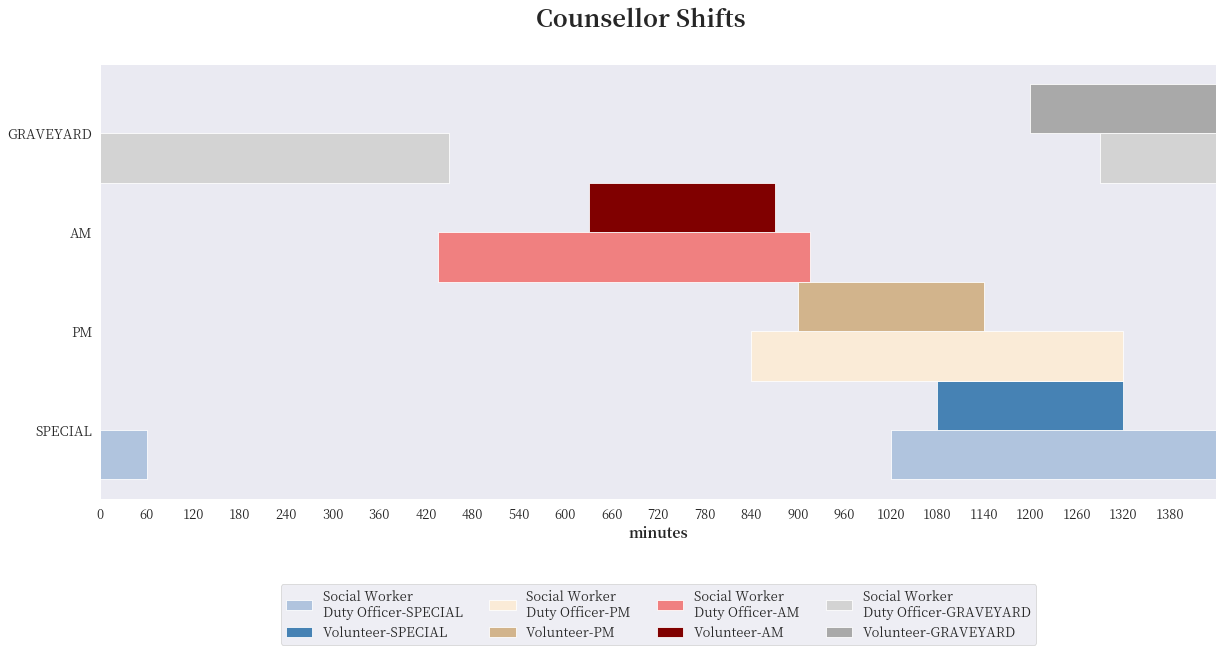

In [4]:
fig, ax = plt.subplots( figsize=(20, 8))
ax.set_xlim(0, 1440)


# special
ax.broken_barh([(SocialWorkerShifts.SPECIAL.start, 1440),
    (0, SocialWorkerShifts.SPECIAL.end%1440)],
    (1, 1), facecolors='lightsteelblue',
    label=f'Social Worker\nDuty Officer-{SocialWorkerShifts.SPECIAL.shift_name}')
ax.broken_barh([(VolunteerShifts.SPECIAL.start,
    VolunteerShifts.PM.duration)],
    (2, 1), facecolors='steelblue',
    label=f'Volunteer-{VolunteerShifts.SPECIAL.shift_name}')


# PM
ax.broken_barh([(SocialWorkerShifts.PM.start,
    SocialWorkerShifts.PM.duration)],
    (3, 1), facecolors='antiquewhite',
    label=f'Social Worker\nDuty Officer-{SocialWorkerShifts.PM.shift_name}'
)
ax.broken_barh([(VolunteerShifts.PM.start,
    VolunteerShifts.PM.duration)],
    (4, 1), facecolors='tan',
    label=f'Volunteer-{VolunteerShifts.PM.shift_name}'
)



# AM
ax.broken_barh([(SocialWorkerShifts.AM.start, 
    SocialWorkerShifts.AM.duration)],
    (5, 1), facecolors='lightcoral',
    label=f'Social Worker\nDuty Officer-{SocialWorkerShifts.AM.shift_name}'
)
ax.broken_barh([(VolunteerShifts.AM.start, 
    VolunteerShifts.AM.duration)],
    (6, 1), facecolors='maroon',
    label=f'Volunteer-{VolunteerShifts.AM.shift_name}'
)


# graveyard
ax.broken_barh([(SocialWorkerShifts.GRAVEYARD.start, 1440),
    (0, SocialWorkerShifts.GRAVEYARD.end%1440)],
    (7, 1), facecolors='lightgrey',
    label=f'Social Worker\nDuty Officer-{SocialWorkerShifts.GRAVEYARD.shift_name}'              
)
ax.broken_barh([(VolunteerShifts.GRAVEYARD.start,
    VolunteerShifts.GRAVEYARD.end)],
    (8, 1), facecolors='darkgrey',
    label=f'Volunteer-{VolunteerShifts.GRAVEYARD.shift_name}',
)


ax.set_xticks([x for x in range(0, 1440, 60)])
ax.set_xlabel('minutes')
ax.set_yticks([x for x in range(2, 9 , 2)])
ax.set_yticklabels([
    SocialWorkerShifts.GRAVEYARD.shift_name,
    SocialWorkerShifts.AM.shift_name,
    SocialWorkerShifts.PM.shift_name,
    SocialWorkerShifts.SPECIAL.shift_name,
    ][::-1])

fig.suptitle('Counsellor Shifts', fontweight='bold', fontsize=24)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.35), ncol=4)

plt.show()

# 2. Queue Simulation (multi-process to speed up bootstrap)

In [5]:
import multiprocessing as mp

In [6]:
manager = mp.Manager()

In [7]:
queue_status = manager.list()
max_queue_length = manager.list()
num_users = manager.list()
num_users_accepted_TOS = manager.list()
num_users_rejected_TOS = manager.list()
num_users_served = manager.list()
num_users_served_g_regular = manager.list()
num_users_served_g_repeated = manager.list()
num_users_reneged = manager.list()
# num_users_reneged_g_regular = manager.list()
# num_users_reneged_g_repeated = manager.list()
num_available_counsellor_processes = manager.list()
queue_time_stats = manager.list()
renege_time_stats = manager.list()
case_chat_time = manager.list()

In [8]:
# comment out line if not reproducing results
random.seed(728)
num_iterations = 1500 # this should be multiples of num_cores
num_cores = max(mp.cpu_count()-2, 2)

In [9]:
def run_simulation(
        queue_status,
        max_queue_length,
        num_users,
        num_users_accepted_TOS,
        num_users_rejected_TOS,
        num_users_served,
        num_users_served_g_regular,
        num_users_served_g_repeated,
        num_users_reneged,
        num_available_counsellor_processes,
        queue_time_stats,
        renege_time_stats,
        case_chat_time):

    for i in tqdm(
        range(num_iterations//num_cores), 
        desc='OpenUp Queue Simulation'):

        try:
            # create environment
            env = simpy.Environment() 

            # set up service operation and run simulation until  
            S = ServiceOperation(env=env)
            env.run(until=SIMULATION_DURATION)


            num_users.append(S.num_users)   
            num_users_accepted_TOS.append(S.num_users_TOS_accepted)
            num_users_rejected_TOS.append(S.num_users_TOS_rejected)
            max_queue_length.append(S.user_queue_max_length)
            
            queue_status.append(pd.DataFrame(S.queue_status) )
            num_available_counsellor_processes.append(
                pd.DataFrame(S.num_available_counsellor_processes,
                             columns=['time', 'num_counsellor_processes_idle'])
            )
            
            num_users_served.append(S.served)
            num_users_served_g_regular.append(S.served_g_regular)
            num_users_served_g_repeated.append(S.served_g_repeated)
            num_users_reneged.append(S.reneged)
            
            queue_time_stats.append(pd.DataFrame(S.queue_time_stats) )
            renege_time_stats.append(pd.DataFrame(S.renege_time_stats) )
            case_chat_time.append(pd.DataFrame(S.case_chat_time,
                                            columns=['cumulative_chat_time']) )
            
        #     num_users_reneged_g_regular.append(S.reneged_g_regular)
        #     num_users_reneged_g_repeated.append(S.reneged_g_repeated)
        except ValueError:
            print(f'Negative delay at {i}.  Results are dropped.')

## divide up jobs to `num_cores`, and merge results when complete

In [10]:
jobs = [mp.Process(target=run_simulation, args=[
            queue_status,
            max_queue_length,
            num_users,
            num_users_accepted_TOS,
            num_users_rejected_TOS,
            num_users_served,
            num_users_served_g_regular,
            num_users_served_g_repeated,
            num_users_reneged,
            num_available_counsellor_processes,
            queue_time_stats,
            renege_time_stats,
            case_chat_time
        ]) for i in range(num_cores)]        
    
for j in jobs:
    j.start()
    
    
for j in jobs:
    j.join()

OpenUp Queue Simulation: 100%|██████████| 250/250 [05:38<00:00,  1.35s/it]


## convert to pandas objects

In [11]:
num_users = pd.Series(np.array(num_users), name='number of users')
num_users_accepted_TOS = pd.Series(np.array(num_users_accepted_TOS), name='number of users accepting TOS')
num_users_rejected_TOS = pd.Series(np.array(num_users_rejected_TOS), name='number of users rejecting TOS')
num_users_served = pd.Series(np.array(num_users_served), name='number of users served')
num_users_served_g_regular = pd.Series(np.array(num_users_served_g_regular), name='number of users served')
num_users_served_g_repeated = pd.Series(np.array(num_users_served_g_repeated), name='number of repeated users served')
num_users_reneged = pd.Series(np.array(num_users_reneged), name='number of users reneged')
# num_users_reneged_g_regular = pd.Series(num_users_reneged_g_regular, name='number of users reneged')
# num_users_reneged_g_repeated = pd.Series(num_users_reneged_g_repeated, name='number of repeated users reneged')
queue_status = pd.concat(queue_status)
max_queue_length = pd.Series(np.array(max_queue_length), name='max queue length')
queue_time_stats = pd.concat(queue_time_stats)
renege_time_stats = pd.concat(renege_time_stats)
num_available_counsellor_processes = pd.concat(num_available_counsellor_processes)
case_chat_time = pd.concat(case_chat_time)

In [12]:
# function to calculate classification confidence intervals
# parameter: stats - list of confidence intervals, which must be ordered
#            metadata - any string to annotate printout, can be None
# precondition - metadata must be a string or None, and stats must be a list
#                  The check is commented out for now as asserts should 
#               be done outside function
# returns: cutoff values at 2.5% and 95% percentiles
def calculate_confidence_intervals(stats, metadata=None):
    # if not isinstance(metadata, None) or \
    #     not isinstance(metadata, str) or \
    #     not isinstance(stats, list):
    #     return
        
    confidence_interval = .95 # 95 percent confidence level
    q_lower = .5 * (1 - confidence_interval)
    q_upper = confidence_interval + q_lower
        
    # convert to percentages
    q_lower = q_lower * 100
    q_upper = q_upper * 100
    confidence_interval = confidence_interval * 100
        
    #     print(q_lower, q_upper)
    lower_percentile = np.percentile(stats, q_lower)
    upper_percentile = np.percentile(stats, q_upper)
    mean = np.mean(stats)
        
    print('\n%s %d%% Confidence interval:' % (
        metadata, confidence_interval) )
    print('----------------------------')
    print('%.1f%% percentile: %.5f' % (q_lower, lower_percentile) )
    print('%.1f%% percentile: %.5f\n' % (q_upper, upper_percentile) )
    print('mean value: %.5f' % mean)
    return (lower_percentile, upper_percentile, mean)

In [13]:
def plot_distribution(series, filename):
    confidence_interval = .95 # 95 percent confidence level
    q_lower = .5 * (1 - confidence_interval)
    q_upper = confidence_interval + q_lower
        
    # convert to percentages
    q_lower = q_lower * 100
    q_upper = q_upper * 100
    confidence_interval = confidence_interval * 100
        
    #     print(q_lower, q_upper)
    lower_percentile = np.percentile(series, q_lower)
    upper_percentile = np.percentile(series, q_upper)
    mean = np.mean(series)
    
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5) )
    sns.distplot(series, ax=ax)
    ax.axvline(x=lower_percentile, linestyle='--' )
    ax.axvline(x=upper_percentile, linestyle='--' )
    ax.axvline(x=mean, linestyle=':', linewidth=2 )
    
    fig.savefig(f'{filename}.png', dpi=300, bbox_inches='tight')

/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


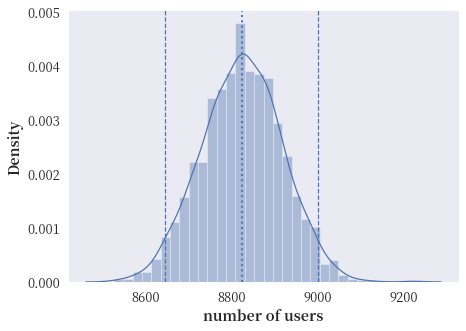

In [14]:
plot_distribution(num_users, 'num_users')

In [15]:
lower, upper, mean = calculate_confidence_intervals(
    num_users.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 8644.00000
97.5% percentile: 8999.00000

mean value: 8823.47200


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


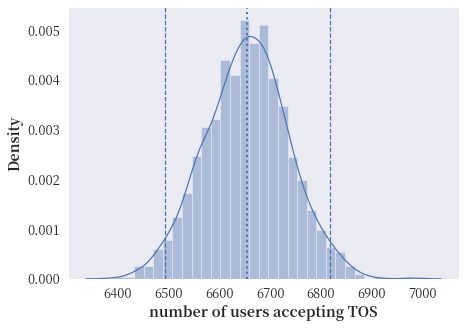

In [16]:
plot_distribution(num_users_accepted_TOS, 'num_users_accepting_TOS')

In [17]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_accepted_TOS.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 6493.47500
97.5% percentile: 6816.52500

mean value: 6654.63467


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


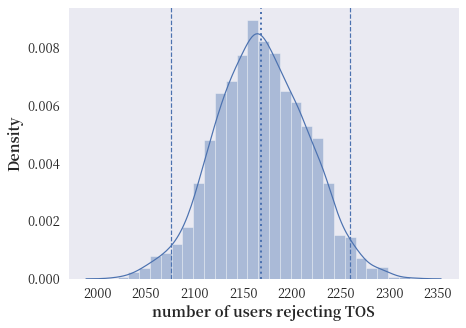

In [18]:
plot_distribution(num_users_rejected_TOS, 'num_users_rejecting_TOS')

In [19]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_rejected_TOS.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 2075.47500
97.5% percentile: 2259.52500

mean value: 2168.83733


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


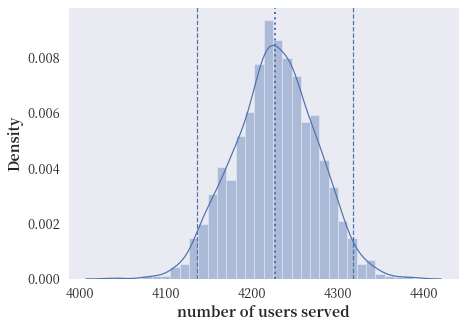

In [20]:
plot_distribution(num_users_served, 'num_users_served')

In [21]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_served.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 4136.00000
97.5% percentile: 4317.00000

mean value: 4226.87933


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


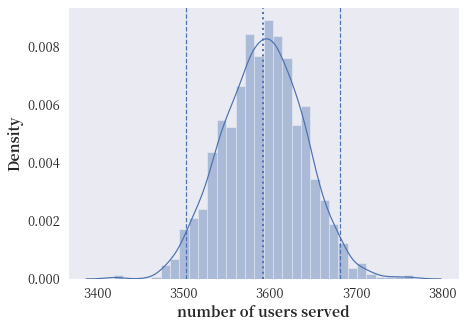

In [22]:
plot_distribution(num_users_served_g_regular, 'num_users_served_g_regular')

In [23]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_served_g_regular.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 3503.00000
97.5% percentile: 3681.52500

mean value: 3592.34400


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


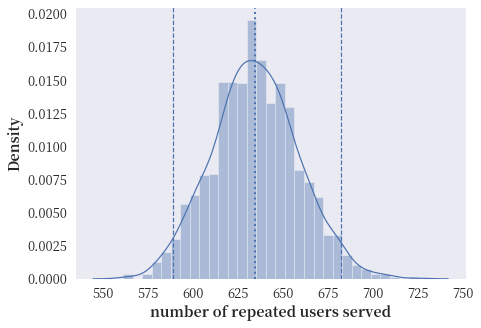

In [24]:
plot_distribution(num_users_served_g_repeated, 'num_users_served_g_repeated')

In [25]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_served_g_repeated.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 588.47500
97.5% percentile: 682.00000

mean value: 634.53533


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


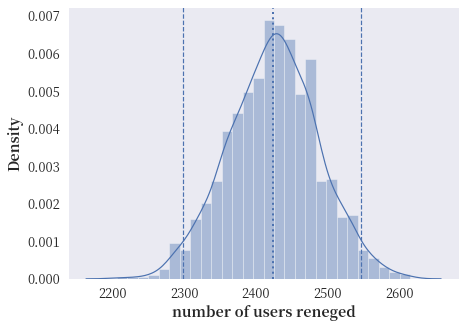

In [26]:
plot_distribution(num_users_reneged, 'num_users_reneged')

In [27]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_reneged.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 2298.00000
97.5% percentile: 2546.05000

mean value: 2424.31200


In [28]:
# plot_distribution(num_users_reneged_g_regular, 'num_users_reneged_g_regular')

In [29]:
# lower, upper, mean = calculate_confidence_intervals(
#     num_users_reneged_g_regular.sort_values().to_list() )

In [30]:
# plot_distribution(num_users_reneged_g_repeated, 'num_users_reneged_g_repeated')

In [31]:
# lower, upper, mean = calculate_confidence_intervals(
#     num_users_reneged_g_repeated.sort_values().to_list() )

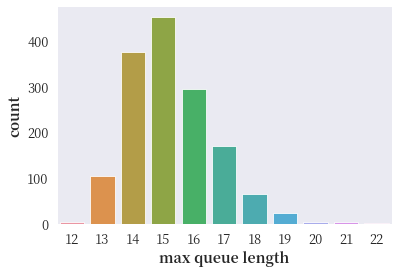

In [33]:
max_queue_length_count = sns.countplot(x='max queue length', data=max_queue_length.to_frame())

max_queue_length_count.get_figure().savefig(f'max_queue_length_count.png', dpi=300, bbox_inches='tight')

In [34]:
queue_status['weekday'].replace({
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
}, inplace=True)

In [35]:
queue_status

,weekday,hour,queue_length
0,Sunday,0,0
1,Sunday,0,0
2,Sunday,0,0
3,Sunday,0,0
4,Sunday,0,0
...,...,...,...
7378,Monday,23,1
7379,Monday,23,0
7380,Monday,23,0
7381,Monday,23,0


In [36]:
queue_status['total']=1

# chat time

In [37]:
case_chat_time.describe().T

,count,mean,std,min,25%,50%,75%,max
cumulative_chat_time,6326845.0,52.328957,39.188773,0.000093,23.434369,43.191557,71.312974,555.473898


In [38]:
# case_chat_time[case_chat_time['cumulative_chat_time']>0].describe().T

<AxesSubplot:xlabel='cumulative_chat_time', ylabel='Count'>

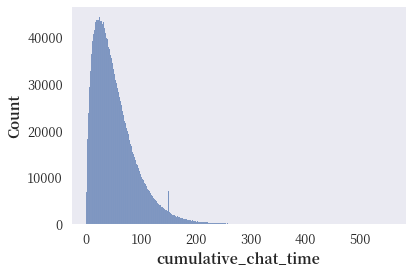

In [39]:
sns.histplot(case_chat_time['cumulative_chat_time'])

<AxesSubplot:xlabel='cumulative_chat_time', ylabel='Density'>

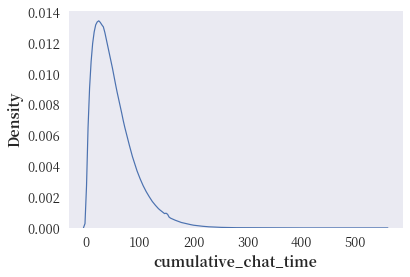

In [40]:
sns.kdeplot(case_chat_time['cumulative_chat_time'])

# queue length

In [41]:
totals = queue_status.groupby(
    ['weekday', 'hour', 'queue_length']).sum()

In [42]:
totals = totals.reset_index()

In [43]:
totals

,weekday,hour,queue_length,total
0,Friday,0,0,764
1,Friday,0,1,2559
2,Friday,0,2,5686
3,Friday,0,3,9143
4,Friday,0,4,12211
...,...,...,...,...
1989,Wednesday,23,15,47
1990,Wednesday,23,16,18
1991,Wednesday,23,17,8
1992,Wednesday,23,18,2


In [44]:
totals = pd.pivot_table(totals, values='total', columns=['queue_length'],
              index=['weekday', 'hour'], aggfunc=np.sum, fill_value=0)

In [45]:
totals_percent = totals.div(totals.sum(axis=1), axis=0)#.round(2)

In [46]:
totals_percent

queue_length          0         1         2         3         4         5   \
weekday   hour                                                               
Friday    0     0.007456  0.024974  0.055492  0.089230  0.119172  0.138203   
          1     0.046560  0.103540  0.166777  0.191621  0.176959  0.134933   
          2     0.150335  0.209064  0.225832  0.181834  0.117652  0.064648   
          3     0.228151  0.252669  0.231132  0.152701  0.080972  0.034986   
          4     0.136104  0.231996  0.254640  0.199141  0.108145  0.047871   
...                  ...       ...       ...       ...       ...       ...   
Wednesday 19    0.965554  0.027320  0.005692  0.001094  0.000192  0.000074   
          20    0.890466  0.047541  0.029403  0.016616  0.009102  0.003961   
          21    0.282772  0.083773  0.102540  0.110803  0.108410  0.096015   
          22    0.041123  0.063619  0.104848  0.136237  0.148999  0.142505   
          23    0.042016  0.066511  0.108988  0.146006  0.155950  0.147730   

queue_length          6         7         8         9   ...        13  \
weekday   hour                                          ...             
Friday    0     0.138496  0.127497  0.105529  0.077334  ...  0.008393   
          1     0.086942  0.049052  0.024500  0.011202  ...  0.000278   
          2     0.030956  0.012499  0.004561  0.001805  ...  0.000000   
          3     0.013010  0.004552  0.001363  0.000347  ...  0.000000   
          4     0.015797  0.004535  0.001442  0.000330  ...  0.000000   
...                  ...       ...       ...       ...  ...       ...   
Wednesday 19    0.000015  0.000015  0.000015  0.000015  ...  0.000000   
          20    0.001770  0.000813  0.000249  0.000066  ...  0.000000   
          21    0.075769  0.055135  0.036837  0.022372  ...  0.001528   
          22    0.120945  0.093503  0.063952  0.040309  ...  0.002530   
          23    0.119873  0.086905  0.056985  0.033682  ...  0.001811   

queue_length          14        15        16        17        18        19  \
weekday   hour                                                               
Friday    0     0.004294  0.001845  0.000742  0.000156  0.000059  0.000020   
          1     0.000133  0.000080  0.000000  0.000000  0.000000  0.000000   
          2     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
          3     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
          4     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                  ...       ...       ...       ...       ...       ...   
Wednesday 19    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
          20    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
          21    0.000606  0.000234  0.000154  0.000049  0.000000  0.000000   
          22    0.001269  0.000464  0.000158  0.000035  0.000000  0.000000   
          23    0.000749  0.000409  0.000157  0.000070  0.000017  0.000009   

queue_length     20   21   22  
weekday   hour                 
Friday    0     0.0  0.0  0.0  
          1     0.0  0.0  0.0  
          2     0.0  0.0  0.0  
          3     0.0  0.0  0.0  
          4     0.0  0.0  0.0  
...             ...  ...  ...  
Wednesday 19    0.0  0.0  0.0  
          20    0.0  0.0  0.0  
          21    0.0  0.0  0.0  
          22    0.0  0.0  0.0  
          23    0.0  0.0  0.0  

[168 rows x 23 columns]

In [47]:
totals_percent2 = totals_percent.reset_index()

In [48]:
totals_percent2['day_int'] = totals_percent2['weekday'].map({
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 0,
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4
})

In [49]:
totals_percent2 = totals_percent2.sort_values(
    by=['day_int', 'hour']).reset_index(drop=True).set_index(
    ['weekday', 'hour']).drop(columns=['day_int'])

In [50]:
totals_percent2['>=2'] = totals_percent2[totals_percent2.columns[totals_percent2.columns >= 2]].sum(axis=1)

In [51]:
totals_percent2.reset_index(inplace=True)

In [52]:
totals_percent3 = totals_percent2[['weekday', 'hour', 0, 1, '>=2']].copy()

In [53]:
from queue_simulation import (
    MINUTES_PER_DAY, DAYS_IN_WEEK, MINUTES_PER_HOUR, 
    MAX_SIMULTANEOUS_CHATS,
    NUM_DUTY_OFFICERS,
    NUM_SOCIAL_WORKERS,
    NUM_VOLUNTEERS
)

In [54]:
NUM_DUTY_OFFICERS

{'GRAVEYARD': 1, 'AM': 1, 'PM': 1, 'SPECIAL': 0}

In [55]:
MAX_SIMULTANEOUS_CHATS

{'SOCIAL_WORKER': 3, 'DUTY_OFFICER': 1, 'VOLUNTEER': 2}

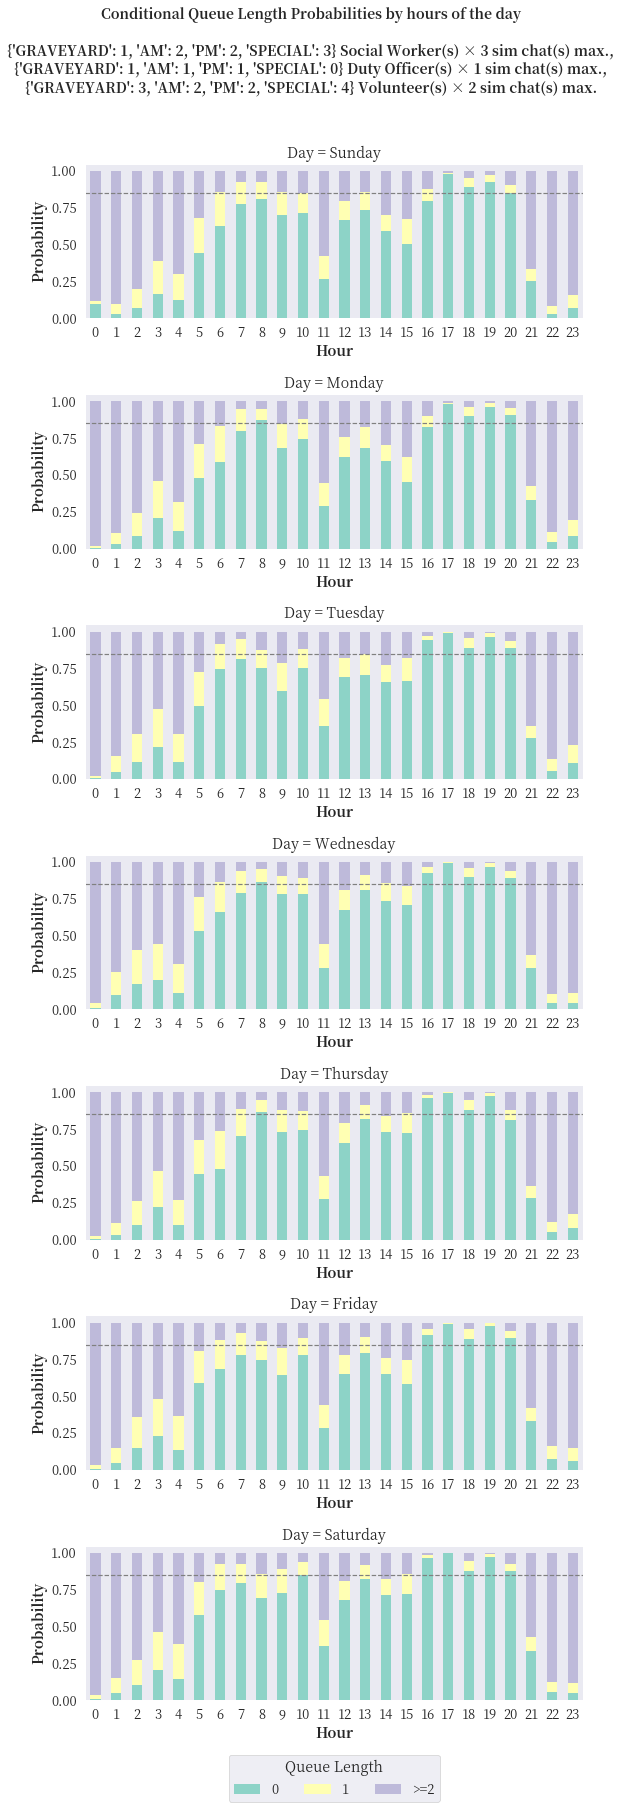

In [56]:
fig, ax = plt.subplots(7, 1, figsize=(8,25) )
palette = sns.color_palette("Set3")

fig.suptitle(f'Conditional Queue Length Probabilities by hours of the day\n\n'
    f'{NUM_SOCIAL_WORKERS} Social Worker(s) × {MAX_SIMULTANEOUS_CHATS["SOCIAL_WORKER"]} sim chat(s) max.,\n'
    f'{NUM_DUTY_OFFICERS} Duty Officer(s) × {MAX_SIMULTANEOUS_CHATS["DUTY_OFFICER"]} sim chat(s) max.,\n'
    f'{NUM_VOLUNTEERS} Volunteer(s) × {MAX_SIMULTANEOUS_CHATS["VOLUNTEER"]} sim chat(s) max.',
    fontsize=14, weight='heavy',
    fontweight=1000, y=1.01)

for i, day in enumerate(
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
    'Friday', 'Saturday']):
    
    dataframe = totals_percent3[totals_percent3['weekday']==day].copy()
    dataframe.set_index('hour').plot.bar(
        stacked=True,
        ax=ax[i],
        linewidth=.01,
        color=palette
    )

    ax[i].axhline(y=.85, linestyle='--', color='grey')
#     ax[i].set_xticklabels(labels=[f'{x[:3]}-{x[-1]} hr' 
#         if x[-2:] == '_0' else ''
#         for x in dataframe.index])

    ax[i].set_xlabel('Hour')
    ax[i].set_ylabel('Probability')
    ax[i].set_title(f'Day = {day}')
    ax[i].set_xticklabels(dataframe['hour'], rotation=0)
    
    
    
    if day == 'Saturday':
        ax[i].legend(loc='lower center', 
                     bbox_to_anchor=(0.5, -.7), 
                     ncol=3,
                     title='Queue Length'
                    
                    )
    else:
        ax[i].get_legend().remove()

    
fig.tight_layout()

fig.savefig(f'queue_length_prob_plot.png', dpi=300, bbox_inches='tight')

# queue time

In [57]:
# queue_plot = sns.catplot(col='weekday', y='hour', col_wrap=4,
#     col_order=['Sunday',
#         'Monday',
#         'Tuesday',
#         'Wednesday',
#         'Thursday',
#         'Friday',
#         'Saturday'],
#     data=queue_status, kind="count",
#     height=4, aspect=1);
# queue_plot.savefig(f'queue_blowup.png', dpi=300, bbox_inches='tight')

In [58]:
queue_time_stats['weekday'].replace({
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
}, inplace=True)

In [59]:
queue_time_stats

,weekday,hour,time_spent_in_queue
0,Sunday,0,0.000000
1,Sunday,0,0.000000
2,Sunday,0,0.000000
3,Sunday,0,0.000000
4,Sunday,0,0.000000
...,...,...,...
4679,Monday,23,45.437621
4680,Monday,23,44.169206
4681,Monday,23,0.000000
4682,Monday,23,0.000000


In [60]:
queue_time_stats['total']=1

In [61]:
# # totals = 
# queue_time_stats.mean()

In [62]:
queue_time_stats['queue_time_group'] = queue_time_stats['time_spent_in_queue'].apply(
    lambda x: 'direct' if x==0 else '<=5 minutes' if x<=5 and x>0 else '>5 minutes')

In [63]:
queue_time_stats['queue_time_group']

0           direct
1           direct
2           direct
3           direct
4           direct
           ...    
4679    >5 minutes
4680    >5 minutes
4681        direct
4682        direct
4683    >5 minutes
Name: queue_time_group, Length: 6919144, dtype: object

In [64]:
queue_time_stats = pd.pivot_table(queue_time_stats, values='total', columns=['queue_time_group'],
              index=['weekday', 'hour'], aggfunc=np.sum, fill_value=0)

In [65]:
queue_time_stats

queue_time_group  <=5 minutes  >5 minutes  direct
weekday   hour                                   
Friday    0               307       14142     236
          1               630       13669     492
          2              1114       11223    1432
          3              1522       10086    2514
          4               309        2475     526
...                       ...         ...     ...
Wednesday 19              485         219   66713
          20             4690        4698   63881
          21            11251       33440   34354
          22             2901       36415    2746
          23             3133       38163    1625

[168 rows x 3 columns]

In [66]:
queue_time_stats.div(queue_time_stats.sum(axis=1), axis=0)

queue_time_group  <=5 minutes  >5 minutes    direct
weekday   hour                                     
Friday    0          0.020906    0.963023  0.016071
          1          0.042593    0.924143  0.033263
          2          0.080906    0.815092  0.104002
          3          0.107775    0.714205  0.178020
          4          0.093353    0.747734  0.158912
...                       ...         ...       ...
Wednesday 19         0.007194    0.003248  0.989558
          20         0.064011    0.064120  0.871869
          21         0.142337    0.423050  0.434613
          22         0.068970    0.865746  0.065285
          23         0.072995    0.889145  0.037860

[168 rows x 3 columns]

In [67]:
queue_time_stats_percent = (queue_time_stats.div(queue_time_stats.sum(axis=1), axis=0))#.round(2)

In [68]:
queue_time_stats

queue_time_group  <=5 minutes  >5 minutes  direct
weekday   hour                                   
Friday    0               307       14142     236
          1               630       13669     492
          2              1114       11223    1432
          3              1522       10086    2514
          4               309        2475     526
...                       ...         ...     ...
Wednesday 19              485         219   66713
          20             4690        4698   63881
          21            11251       33440   34354
          22             2901       36415    2746
          23             3133       38163    1625

[168 rows x 3 columns]

In [69]:
queue_time_stats2 = queue_time_stats_percent.reset_index()

In [70]:
queue_time_stats2['day_int'] = queue_time_stats2['weekday'].map({
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 0,
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4
})

In [71]:
queue_time_stats2 = queue_time_stats2.sort_values(
    by=['day_int', 'hour']).reset_index(drop=True).set_index(
    ['weekday', 'hour']).drop(columns=['day_int'])

In [72]:
queue_time_stats2

queue_time_group  <=5 minutes  >5 minutes    direct
weekday  hour                                      
Sunday   0           0.017581    0.565048  0.417371
         1           0.034569    0.943544  0.021887
         2           0.056738    0.893998  0.049264
         3           0.088934    0.790890  0.120176
         4           0.112476    0.699275  0.188249
...                       ...         ...       ...
Saturday 19          0.005482    0.003140  0.991378
         20          0.068777    0.073471  0.857751
         21          0.122945    0.388680  0.488376
         22          0.073775    0.782821  0.143404
         23          0.074707    0.886602  0.038690

[168 rows x 3 columns]

In [73]:
queue_time_stats2.reset_index(inplace=True)

In [74]:
queue_time_stats2

queue_time_group,weekday,hour,<=5 minutes,>5 minutes,direct
0,Sunday,0,0.017581,0.565048,0.417371
1,Sunday,1,0.034569,0.943544,0.021887
2,Sunday,2,0.056738,0.893998,0.049264
3,Sunday,3,0.088934,0.790890,0.120176
4,Sunday,4,0.112476,0.699275,0.188249
...,...,...,...,...,...
163,Saturday,19,0.005482,0.003140,0.991378
164,Saturday,20,0.068777,0.073471,0.857751
165,Saturday,21,0.122945,0.388680,0.488376
166,Saturday,22,0.073775,0.782821,0.143404


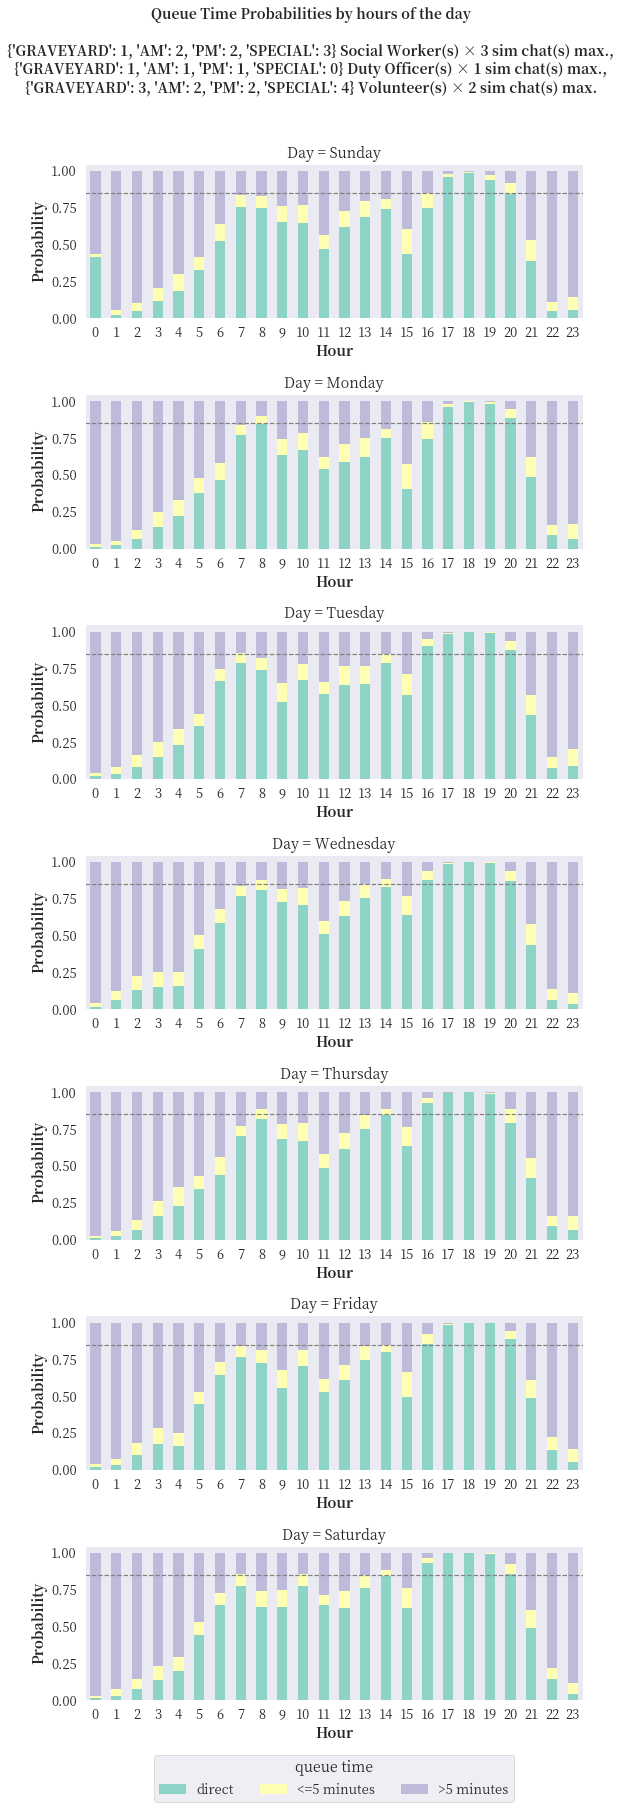

In [75]:
fig, ax = plt.subplots(7, 1, figsize=(8,25) )
palette = sns.color_palette("Set3")

fig.suptitle(f'Queue Time Probabilities by hours of the day\n\n'
    f'{NUM_SOCIAL_WORKERS} Social Worker(s) × {MAX_SIMULTANEOUS_CHATS["SOCIAL_WORKER"]} sim chat(s) max.,\n'
    f'{NUM_DUTY_OFFICERS} Duty Officer(s) × {MAX_SIMULTANEOUS_CHATS["DUTY_OFFICER"]} sim chat(s) max.,\n'
    f'{NUM_VOLUNTEERS} Volunteer(s) × {MAX_SIMULTANEOUS_CHATS["VOLUNTEER"]} sim chat(s) max.',
    fontsize=14, weight='heavy',
    fontweight=1000, y=1.01)

for i, day in enumerate(
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
    'Friday', 'Saturday']):
    
    dataframe = queue_time_stats2[queue_time_stats2['weekday']==day].copy()
    dataframe[['weekday', 'hour', 'direct', 
         '<=5 minutes', '>5 minutes']
    ].set_index('hour').plot.bar(
        stacked=True,
        ax=ax[i],
        linewidth=.01,
        color=palette
    )

    ax[i].axhline(y=.85, linestyle='--', color='grey')

    ax[i].set_xlabel('Hour')
    ax[i].set_ylabel('Probability')
    ax[i].set_title(f'Day = {day}')
    ax[i].set_xticklabels(dataframe['hour'], rotation=0)
    
    
    
    if day == 'Saturday':
        ax[i].legend(loc='lower center', 
                     bbox_to_anchor=(0.5, -.7), 
                     ncol=3,
                     title='queue time'
                    
                    )
    else:
        ax[i].get_legend().remove()

    
fig.tight_layout()

fig.savefig(f'queue_length_prob_plot.png', dpi=300, bbox_inches='tight')

# determine hours counsellors are maxed out

In [76]:
from queue_simulation import (
    MINUTES_PER_DAY, DAYS_IN_WEEK, MINUTES_PER_HOUR)

In [77]:
num_available_counsellor_processes

,time,num_counsellor_processes_idle
0,4.837379,12
1,13.558973,11
2,17.530240,10
3,29.947705,9
4,34.052108,8
...,...,...
7378,43176.653057,10
7379,43177.706084,10
7380,43182.275651,11
7381,43187.544914,10


In [78]:
num_available_counsellor_processes['time_int'] = num_available_counsellor_processes['time'].astype(int)

In [79]:
num_available_counsellor_processes['current_day_minutes'] = num_available_counsellor_processes['time_int'] % MINUTES_PER_DAY

In [80]:
num_available_counsellor_processes['weekday'] = (num_available_counsellor_processes['time_int'] / MINUTES_PER_DAY).astype(int) % DAYS_IN_WEEK

In [81]:
num_available_counsellor_processes['hour'] = (num_available_counsellor_processes['current_day_minutes'] / MINUTES_PER_HOUR).astype(int)

In [82]:
num_available_counsellor_processes['day_of_week'] = num_available_counsellor_processes['weekday'].replace({
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
})

In [83]:
num_available_counsellor_processes['total']=1

In [84]:
num_available_counsellor_processes

,time,num_counsellor_processes_idle,time_int,current_day_minutes,weekday,hour,day_of_week,total
0,4.837379,12,4,4,0,0,Sunday,1
1,13.558973,11,13,13,0,0,Sunday,1
2,17.530240,10,17,17,0,0,Sunday,1
3,29.947705,9,29,29,0,0,Sunday,1
4,34.052108,8,34,34,0,0,Sunday,1
...,...,...,...,...,...,...,...,...
7378,43176.653057,10,43176,1416,1,23,Monday,1
7379,43177.706084,10,43177,1417,1,23,Monday,1
7380,43182.275651,11,43182,1422,1,23,Monday,1
7381,43187.544914,10,43187,1427,1,23,Monday,1


In [85]:
df2 = pd.pivot_table(num_available_counsellor_processes, values='total', columns=['num_counsellor_processes_idle'],
              index=[#'weekday', 'day_of_week', 
                     'hour'], aggfunc=np.sum, fill_value=0)

In [86]:
df2 = (((df2.T/df2.T.sum()).T)*100)#.round(2)

In [87]:
# df2 = df2.reset_index(drop=False).drop(columns=['weekday'])
# selection = df2[df2['day_of_week']=='Monday'].copy()

In [88]:
# df2.groupby('hour').mean()

In [89]:
# selection.set_index(['day_of_week', 'hour']).to_excel(
#     'queue_output/num_idle_procs_SW_2434_DO_11_V_2423-45.xlsx')

In [90]:
queue_time_stats

queue_time_group  <=5 minutes  >5 minutes  direct
weekday   hour                                   
Friday    0               307       14142     236
          1               630       13669     492
          2              1114       11223    1432
          3              1522       10086    2514
          4               309        2475     526
...                       ...         ...     ...
Wednesday 19              485         219   66713
          20             4690        4698   63881
          21            11251       33440   34354
          22             2901       36415    2746
          23             3133       38163    1625

[168 rows x 3 columns]

In [91]:
renege_time_stats['weekday'].replace({
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
}, inplace=True)

In [92]:
renege_time_stats['time_spent_in_queue'].describe()

count    4.141412e+06
mean     1.440571e+01
std      1.078489e+01
min      1.346262e-01
25%      6.901277e+00
50%      1.150636e+01
75%      1.868240e+01
max      1.878096e+02
Name: time_spent_in_queue, dtype: float64

<AxesSubplot:xlabel='time_spent_in_queue', ylabel='Density'>

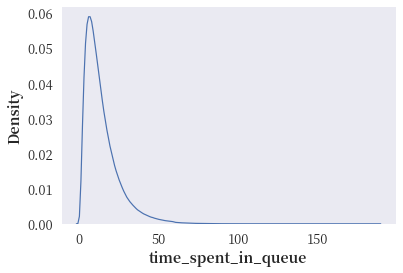

In [93]:
sns.kdeplot(renege_time_stats['time_spent_in_queue'])

<AxesSubplot:xlabel='hour', ylabel='Count'>

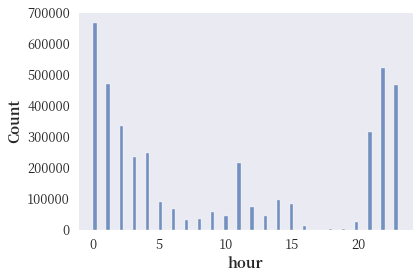

In [94]:
sns.histplot(renege_time_stats['hour'])

In [95]:
df2

num_counsellor_processes_idle,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
hour,,,,,,,,,,,,,,,,,,,,,
0,0.000890,0.027476,0.047575,0.068945,0.109651,0.173635,0.207217,0.234693,0.306819,3.936107,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,69.973745,30.017830,0.007737,0.000688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,28.532177,71.280341,0.177961,0.009521,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.400887,97.901753,0.642452,0.054908,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.585314,98.084201,0.297652,0.032832,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.891762,66.801216,23.394296,8.912726,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.990821,87.267756,9.454033,2.287389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.221267,18.945858,12.800830,15.639256,18.815165,14.392301,8.250996,5.193785,3.634574,1.710169,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.685323,55.417978,17.573355,13.700931,8.224805,3.561836,0.835772,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [96]:
df2['>10'] = df2[df2.columns[df2.columns > 10]].T.sum()

In [97]:
df2 = df2[[x for x in range(11)] + ['>10']].copy()

In [98]:
df2 = df2.T

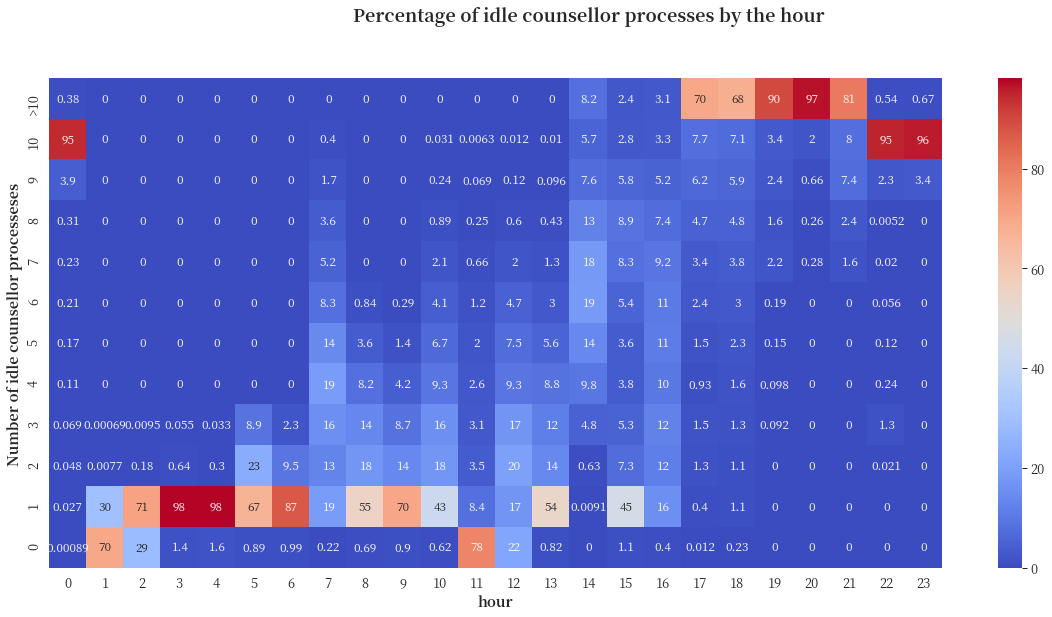

In [99]:
fig, ax = plt.subplots(figsize=(20, 10) )


sns.heatmap(df2[::-1], annot=True, ax=ax, annot_kws={"size": 12}, 
    cmap="coolwarm",
);
fig.suptitle('Percentage of idle counsellor processes by the hour',
    fontsize=18, weight='heavy',
    fontweight=1000)
plt.subplots_adjust(bottom=0.2)
ax.set_ylabel('Number of idle counsellor processeses')

# fig.savefig(f'queue_output/Queue_SW_24_DO_11_V_21.png', dpi=300, bbox_inches='tight')
plt.show()

In [100]:
df2

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
num_counsellor_processes_idle,,,,,,,,,,,,,,,,,,,,,
0,0.000890,69.973745,28.532177,1.400887,1.585314,0.891762,0.990821,0.221267,0.685323,0.903965,...,0.000000,1.063700,0.399113,0.012406,0.228790,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.027476,30.017830,71.280341,97.901753,98.084201,66.801216,87.267756,18.945858,55.417978,70.341245,...,0.009078,45.435807,15.614832,0.395071,1.069853,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.047575,0.007737,0.177961,0.642452,0.297652,23.394296,9.454033,12.800830,17.573355,14.131063,...,0.625433,7.284815,11.847252,1.333872,1.141598,0.000000,0.000000,0.000000,0.021132,0.000000
3,0.068945,0.000688,0.009521,0.054908,0.032832,8.912726,2.287389,15.639256,13.700931,8.734937,...,4.838386,5.321748,12.302094,1.539429,1.256535,0.091910,0.000000,0.000000,1.318131,0.000000
4,0.109651,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.815165,8.224805,4.177278,...,9.842806,3.753484,10.184807,0.926395,1.649959,0.097715,0.000000,0.000000,0.243848,0.000000
5,0.173635,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.392301,3.561836,1.426328,...,13.972383,3.584688,10.919551,1.532584,2.252113,0.148023,0.000000,0.000000,0.120024,0.000000
6,0.207217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.250996,0.835772,0.285184,...,18.627058,5.373279,10.638391,2.383259,2.973360,0.194075,0.000000,0.000000,0.056035,0.000000
7,0.234693,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.193785,0.000000,0.000000,...,18.090972,8.298201,9.227984,3.391364,3.824363,2.195778,0.279082,1.555774,0.019589,0.000000
8,0.306819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.634574,0.000000,0.000000,...,12.500060,8.891017,7.362736,4.660425,4.770967,1.581819,0.256879,2.372784,0.005224,0.000000
